<a href="https://colab.research.google.com/github/zs-eren/KPOP-BTS-Data-Project-DSA210/blob/main/aaa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

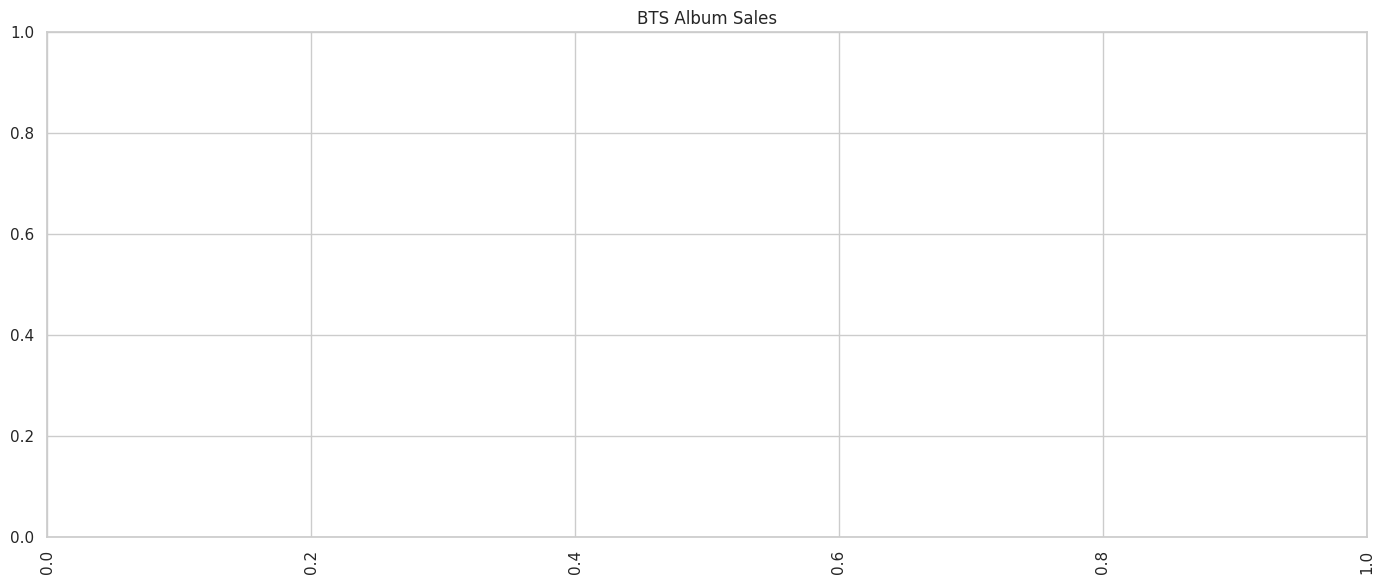

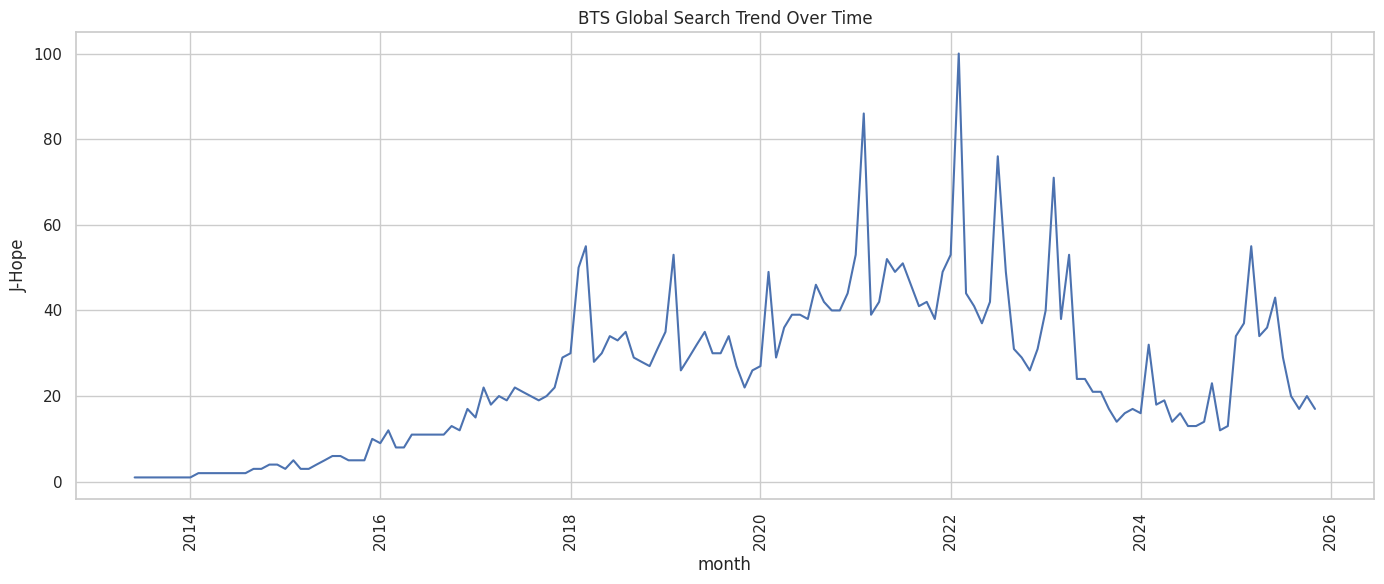

Not enough overlapping years to compute correlation.
Merged dataset size: 0


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import re

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

album = pd.read_csv("/content/bts_album_sales.csv")
trends = pd.read_csv("/content/bts_member_trends.csv")

string_cols_album = [c for c in album.columns if album[c].dtype == "object"]
album_name_col = string_cols_album[0]

numeric_album_cols = [c for c in album.columns if album[c].dtype != "object"]
sales_col = max(numeric_album_cols, key=lambda c: album[c].max())

def extract_year(text):
    match = re.search(r"(20\d{2}|19\d{2})", str(text))
    return int(match.group()) if match else None

album["Year"] = album[album_name_col].apply(extract_year)
album = album.dropna(subset=["Year"])
album["Year"] = album["Year"].astype(int)

date_col = trends.columns[0]
trend_numeric_cols = [c for c in trends.columns[1:] if trends[c].dtype != "object"]

if "BTS" in trends.columns:
    bts_trend_col = "BTS"
else:
    bts_trend_col = trend_numeric_cols[0]

trends[date_col] = pd.to_datetime(trends[date_col], errors="coerce")
trends = trends.dropna(subset=[date_col])
trends["Year"] = trends[date_col].dt.year

plt.figure(figsize=(14,6))
sns.barplot(data=album, x=album_name_col, y=sales_col)
plt.xticks(rotation=90)
plt.title("BTS Album Sales")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,6))
sns.lineplot(data=trends, x=date_col, y=bts_trend_col)
plt.xticks(rotation=90)
plt.title("BTS Global Search Trend Over Time")
plt.tight_layout()
plt.show()

yearly_trend = trends.groupby("Year")[bts_trend_col].mean().reset_index()
yearly_trend.rename(columns={bts_trend_col: "YearlyTrend"}, inplace=True)

merged = pd.merge(album, yearly_trend, on="Year", how="left")
merged_clean = merged.dropna(subset=["YearlyTrend"])

if len(merged_clean) >= 2:
    corr, p_val = pearsonr(merged_clean[sales_col], merged_clean["YearlyTrend"])
    print("Correlation:", corr)
    print("p-value:", p_val)

    plt.figure(figsize=(8,5))
    plt.scatter(merged_clean["YearlyTrend"], merged_clean[sales_col], color="red")
    plt.xlabel("BTS Yearly Trend Score")
    plt.ylabel("Album Sales")
    plt.title("Album Sales vs BTS Search Trend")
    plt.tight_layout()
    plt.show()

else:
    print("Not enough overlapping years to compute correlation.")
    print("Merged dataset size:", len(merged_clean))


In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

# Load data (make sure files are in /content/data/)
album = pd.read_csv("/content/bts_album_sales.csv")
members = pd.read_csv("/content/bts_member_trends.csv")
bts = pd.read_csv("/content/BTS_trends.csv")


album.head(), members.head(), bts.head()


(         Map of the Soul: 7  2020  4600000
 0  Map of the Soul: Persona  2019  3500000
 1     Love Yourself: Answer  2018  3100000
 2       Love Yourself: Tear  2018  2200000
 3        Love Yourself: Her  2017  2150000
 4                     Wings  2016  1900000,
      month  J-Hope  RM  Jin  Suga  Jimin  V  Jungkook
 0  2013-06       1   6   10     4      1  2         1
 1  2013-07       1   6   10     4      1  2         1
 2  2013-08       1   6    9     4      1  2         1
 3  2013-09       1   6    9     4      1  2         1
 4  2013-10       1   7    9     4      1  2         1,
         AY  BTS: (Dünya Genelinde)
 0  2013-06                       5
 1  2013-07                       6
 2  2013-08                       4
 3  2013-09                       5
 4  2013-10                       5)

In [22]:
import pandas as pd
import numpy as np

album = pd.read_csv("/content/bts_album_sales.csv", header=None, names=["Album", "Year", "Sales"])

album["Year"] = pd.to_numeric(album["Year"], errors="coerce")
album["Sales"] = pd.to_numeric(album["Sales"], errors="coerce")
album = album.dropna(subset=["Year", "Sales"])
album["Year"] = album["Year"].astype(int)

album.head()


,Album,Year,Sales
0,Map of the Soul: 7,2020,4600000
1,Map of the Soul: Persona,2019,3500000
2,Love Yourself: Answer,2018,3100000
3,Love Yourself: Tear,2018,2200000
4,Love Yourself: Her,2017,2150000


In [23]:
members = pd.read_csv("/content/bts_member_trends.csv")

members["month"] = pd.to_datetime(members["month"], errors="coerce")
members = members.dropna(subset=["month"])
members["Year"] = members["month"].dt.year

member_cols = [c for c in members.columns if c not in ["month", "Year"]]

members_yearly = (
    members
    .groupby("Year", as_index=False)[member_cols]
    .mean()
)

members_yearly.head()


,Year,J-Hope,RM,Jin,Suga,Jimin,V,Jungkook
0,2013,1.000000,6.285714,9.571429,4.000000,1.000000,2.000000,1.285714
1,2014,2.416667,7.666667,10.916667,6.000000,2.083333,3.250000,3.416667
2,2015,5.000000,12.000000,12.333333,10.250000,5.833333,6.000000,7.833333
3,2016,11.166667,16.750000,16.333333,22.416667,13.416667,10.916667,17.833333
4,2017,20.583333,22.583333,17.166667,35.250000,27.333333,19.333333,32.333333


In [24]:
bts = pd.read_csv("/content/BTS_trends.csv")

bts_date_col = bts.columns[0]
bts_score_col = bts.columns[1]

bts[bts_date_col] = pd.to_datetime(bts[bts_date_col], errors="coerce")
bts = bts.dropna(subset=[bts_date_col])

bts["Year"] = bts[bts_date_col].dt.year

bts_yearly = (
    bts
    .groupby("Year", as_index=False)[bts_score_col]
    .mean()
)

bts_yearly = bts_yearly.rename(columns={bts_score_col: "BTS_Trend"})

bts_yearly.head()


,Year,BTS_Trend
0,2013,5.142857
1,2014,8.166667
2,2015,13.000000
3,2016,22.666667
4,2017,40.416667


In [25]:
df = (
    album
    .merge(bts_yearly, on="Year", how="left")
    .merge(members_yearly, on="Year", how="left")
)

df = df.sort_values("Year").reset_index(drop=True)

df


,Album,Year,Sales,BTS_Trend,J-Hope,RM,Jin,Suga,Jimin,V,Jungkook
0,O!RUL8,2013,300000,5.142857,1.000000,6.285714,9.571429,4.000000,1.000000,2.000000,1.285714
1,2 Cool 4 Skool,2013,280000,5.142857,1.000000,6.285714,9.571429,4.000000,1.000000,2.000000,1.285714
2,Skool Luv Affair,2014,380000,8.166667,2.416667,7.666667,10.916667,6.000000,2.083333,3.250000,3.416667
3,Dark & Wild,2014,600000,8.166667,2.416667,7.666667,10.916667,6.000000,2.083333,3.250000,3.416667
4,Wake Up,2014,260000,8.166667,2.416667,7.666667,10.916667,6.000000,2.083333,3.250000,3.416667
5,The Most Beautiful Moment in Life Pt.2,2015,520000,13.000000,5.000000,12.000000,12.333333,10.250000,5.833333,6.000000,7.833333
6,The Most Beautiful Moment in Life Pt.1,2015,430000,13.000000,5.000000,12.000000,12.333333,10.250000,5.833333,6.000000,7.833333
7,The Most Beautiful Moment in Life: Young Forever,2016,1100000,22.666667,11.166667,16.750000,16.333333,22.416667,13.416667,10.916667,17.833333
8,Wings,2016,1900000,22.666667,11.166667,16.750000,16.333333,22.416667,13.416667,10.916667,17.833333
9,Youth,2016,350000,22.666667,11.166667,16.750000,16.333333,22.416667,13.416667,10.916667,17.833333


In [26]:
# Target
y = df["Sales"]

# Features
feature_cols = ["BTS_Trend"] + [c for c in df.columns if c in [
    "J-Hope", "RM", "Jin", "Suga", "Jimin", "V", "Jungkook"
]]

X = df[feature_cols]

X, y


(    BTS_Trend     J-Hope         RM        Jin       Suga      Jimin  \
 0    5.142857   1.000000   6.285714   9.571429   4.000000   1.000000   
 1    5.142857   1.000000   6.285714   9.571429   4.000000   1.000000   
 2    8.166667   2.416667   7.666667  10.916667   6.000000   2.083333   
 3    8.166667   2.416667   7.666667  10.916667   6.000000   2.083333   
 4    8.166667   2.416667   7.666667  10.916667   6.000000   2.083333   
 5   13.000000   5.000000  12.000000  12.333333  10.250000   5.833333   
 6   13.000000   5.000000  12.000000  12.333333  10.250000   5.833333   
 7   22.666667  11.166667  16.750000  16.333333  22.416667  13.416667   
 8   22.666667  11.166667  16.750000  16.333333  22.416667  13.416667   
 9   22.666667  11.166667  16.750000  16.333333  22.416667  13.416667   
 10  40.416667  20.583333  22.583333  17.166667  35.250000  27.333333   
 11  57.750000  34.166667  33.750000  30.750000  52.666667  37.416667   
 12  57.750000  34.166667  33.750000  30.750000  52

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

X_train.shape, X_test.shape


((11, 8), (5, 8))

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred_lr))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))


R2 Score: 0.6283203711916521
MAE: 646457.7084238202


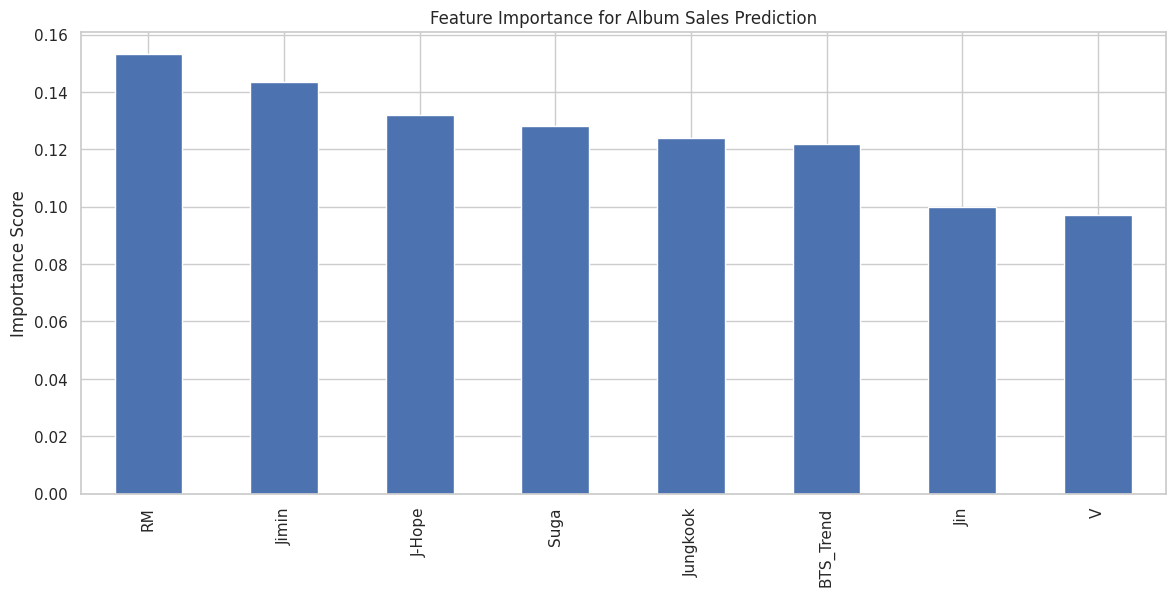

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

importance = pd.Series(
    model_rf.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

importance.plot(kind="bar")
plt.title("Feature Importance for Album Sales Prediction")
plt.ylabel("Importance Score")
plt.show()
